In [1]:
#Importing libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [2]:
#Getting filenames for images for calibration
images=glob.glob('camera_cal/calibration*.jpg')

#Arrays for storing the chessboard corner points
imgpoints=[]
objpoints=[]

#Actual corner points in the chessboard
objp=np.zeros((9*6,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

#Variable used for saving the images
i=0

#Get each chessboard image file name
for fname in images:
    
    #Reading each chessboard image
    img=mpimg.imread(fname)
    
    #Converting to grayscale
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    #Find the corners of the chessboard
    ret, corners = cv2.findChessboardCorners(gray,(9,6),None)
    
    if ret==True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        #Draw the chessboard corners on the images to verify whether the corners are drawn or not and save them
        out=cv2.drawChessboardCorners(img,(9,6),corners,ret)
        cv2.imwrite('output_images/'+fname.split('\\')[-1], out)
        i+=1

#Calibrating the camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [3]:
#Undistorting images
def undistorted_img(img,mtx,dist):
    dst = cv2.undistort(img,mtx,dist,None,mtx)
    return dst

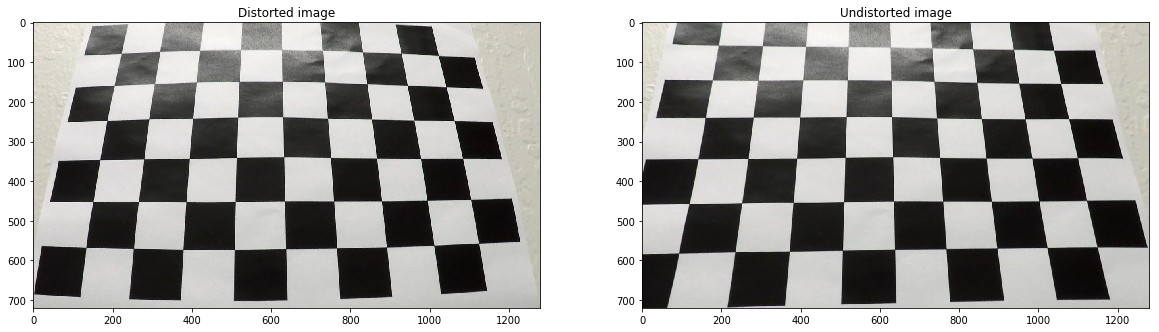

In [55]:
#Undistortion check on chess board image
image_path = 'camera_cal/calibration3.jpg'
image_test = mpimg.imread(image_path)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image_test)
ax1.set_title('Distorted image')
undist=undistorted_img(image_test,mtx,dist)
ax2.imshow(undist)
ax2.set_title('Undistorted image')

#Saving undistorted image
cv2.imwrite('output_images/test1_undist.jpg', undist)

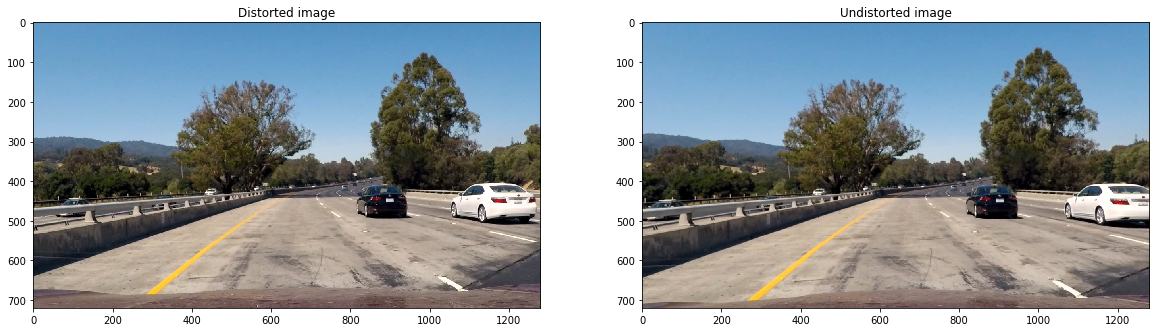

In [6]:
#Undistortion check on road images
image_path = 'test_images/test1.jpg'
image_test = mpimg.imread(image_path)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image_test)
ax1.set_title('Distorted image')
undist=undistorted_img(image_test,mtx,dist)
ax2.imshow(undist)
ax2.set_title('Undistorted image')

#Saving undistorted image
cv2.imwrite('output_images/test1_undist.jpg', undist)

In [4]:
#Functions for Sobel orientation, Sobel magnitude, Sobel Direction and Color thresholding

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    #Convert to grayscale
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    # Calculate directional gradient
    if orient=='x':
        sob_val=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    if orient=='y':
        sob_val=cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel) 
        
    #Calculating absolute value
    abs_sob=np.absolute(sob_val)
    
    #Scale to 8-bit (0 - 255) and convert to type = np.uint8
    norm_sobel=np.uint8(abs_sob*255/np.max(abs_sob))
    
    # Apply threshold
    grad_binary=np.zeros_like(norm_sobel)
    grad_binary[(norm_sobel>=thresh[0])&(norm_sobel<=thresh[1])]=1
    
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    
    #Convert to grayscale
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
    # Calculate directional gradient
    sob_x=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sob_y=cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel) 
    
    #Calculating magnitude value
    abs_sob=np.sqrt((sob_x**2)+(sob_y**2))
    
    #Scale to 8-bit (0 - 255) and convert to type = np.uint8
    norm_sob=np.uint8(abs_sob*255/np.max(abs_sob))
    
    # Apply threshold
    mag_binary=np.zeros_like(norm_sob)
    mag_binary[(norm_sob>=mag_thresh[0]) & (norm_sob<=mag_thresh[1])]=1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    #Convert to grayscale
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
    # Calculate directional gradient
    sobel_x=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobel_y=cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    
    #Calculating absolute value
    sobelx_abs=np.absolute(sobel_x)
    sobely_abs=np.absolute(sobel_y)
    
    #Calculate Sobel direction
    gradient_dir=np.arctan2(sobely_abs,sobelx_abs)
    
    # Apply threshold
    dir_binary=np.zeros_like(gradient_dir)
    dir_binary[(gradient_dir>=thresh[0])&(gradient_dir<=thresh[1])]=1
    return dir_binary

def color_threshold(image, thresh):
    
    #Convert image to HLS color channel
    hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    
    #Extract the S channel image
    s_channel = hls[:,:,2]

    #Applying threshold                
    sxbinary = np.zeros_like(s_channel)
    sxbinary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return sxbinary

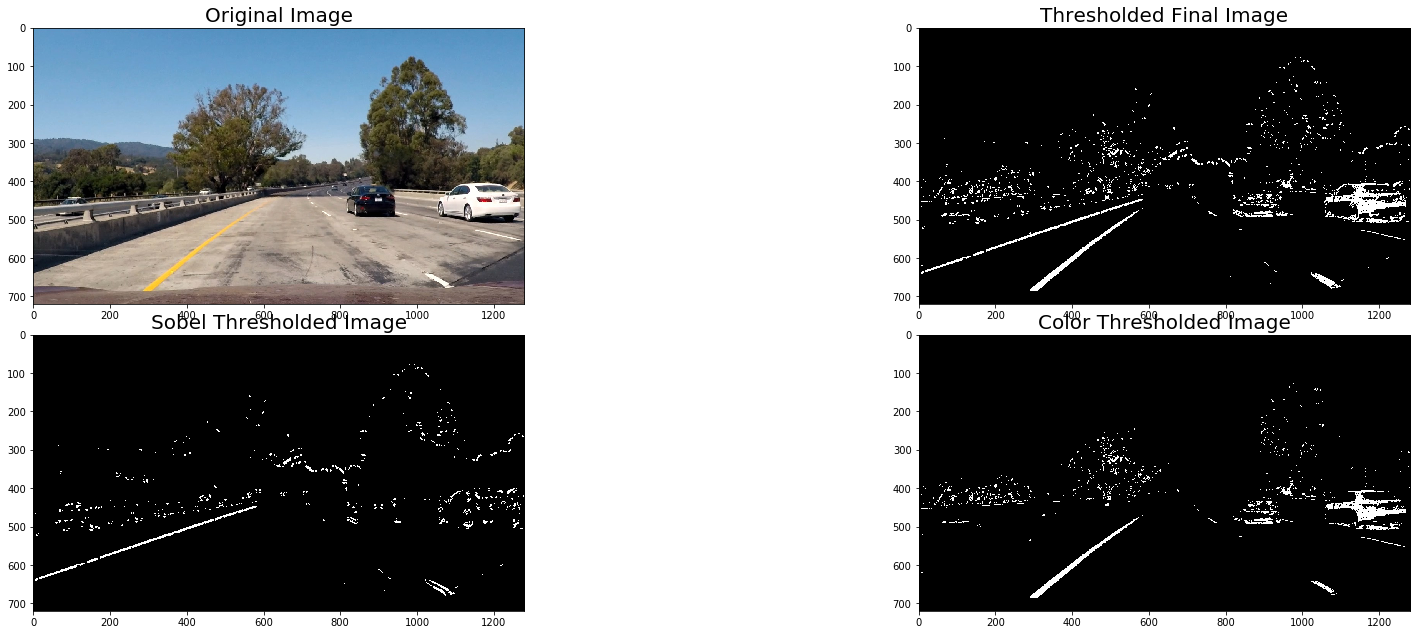

In [5]:
#Printing the thresholded output image
# Read in an image
image = mpimg.imread('test_images/test1.jpg')

# Choose a Sobel kernel size
ksize = 25 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(50, 180))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(50, 180))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(80, 160))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7 ,1.3))

sobel_combined = np.zeros_like(dir_binary)
sobel_combined[((gradx ==1) & (grady ==1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1 

sxbinary = color_threshold(image, thresh=(160,255))

# Combine the Sobel and color binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(sobel_combined == 1) | (sxbinary == 1)] = 1

# Plot the result
f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Thresholded Final Image', fontsize=20)
ax3.imshow(sobel_combined, cmap='gray')
ax3.set_title('Sobel Thresholded Image', fontsize=20)
ax4.imshow(sxbinary, cmap='gray')
ax4.set_title('Color Thresholded Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# #Saving images
cv2.imwrite('output_images/final_thresh.jpg', combined_binary*255)
cv2.imwrite('output_images/sobel_thresh.jpg', sobel_combined*255)
cv2.imwrite('output_images/color_thresh.jpg', sxbinary*255)

In [5]:
#Perspective Transform
def warp(image):
    
    #define source and destination points
    src=np.float32([[559,474],[725,474],[1040,677],[264,677]])
    dst=np.float32([[205,0],[1037,0],[1037,720],[205,720]])
    
    #Get the matrix of perspective transform
    M=cv2.getPerspectiveTransform(src,dst)
    
    #Get the inverse matrix of perspective transform
    Minv=cv2.getPerspectiveTransform(dst,src)
    
    return M,Minv

image=mpimg.imread('test_images/straight_lines1.jpg')
M,Minv=warp(image)

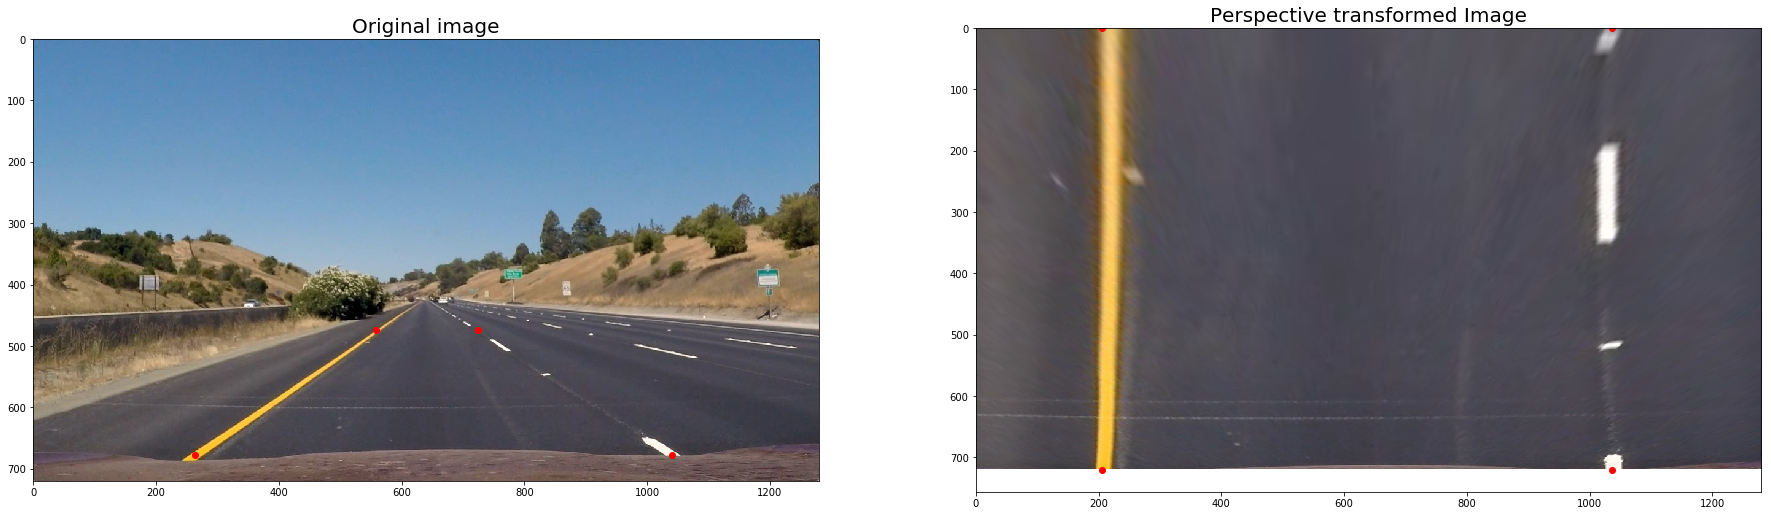

In [7]:
#Perspective Transform on test image and plotting the source and destination images
image=mpimg.imread('test_images/straight_lines1.jpg')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(image)
ax1.set_title('Original image', fontsize=20)
ax1.plot(559,474,'ro-')
ax1.plot(725,474,'ro-')
ax1.plot(1040,677,'ro-')
ax1.plot(264,677,'ro-')
#Get the perspective transformed image
warped_img=cv2.warpPerspective(image,M,image.shape[1::-1],flags=cv2.INTER_LINEAR )
ax2.imshow(warped_img)
ax2.set_title('Perspective transformed Image', fontsize=20)
ax2.plot(205,0,'ro-')
ax2.plot(1037,0,'ro-')
ax2.plot(1037,720,'ro-')
ax2.plot(205,720,'ro-')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [35]:
# Function that identifies lane lines in images
def fit_lane_line(binary_warped):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[(binary_warped.shape[0]//2):,:], axis=0)
    
    #Arrays to storex and y points of left and right lane lines
    leftx=np.empty((0,0))
    lefty=np.empty((0,0))
    rightx=np.empty((0,0))
    righty=np.empty((0,0))

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set the number of sliding windows
    nwindows = 9

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through each windows
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height   #Top edge of the window
        win_y_high = binary_warped.shape[0] - window*window_height   #Bottom edge of the window
        win_xleft_low = leftx_current - margin   #Left edge of left window
        win_xleft_high = leftx_current + margin   #Right edge of left window
        win_xright_low = rightx_current - margin   #Left edge of right window
        win_xright_high = rightx_current + margin   #Right edge of right window
        
        # Draw the windows on the visualization image #Uncomment to display the windows in the image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 5)   #Left Window
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 5)   #Right Window 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
        # Store the current window's center points
        curr_left_window_center_x=np.int32((win_xleft_low+win_xleft_high)/2)
        curr_left_window_center_y=np.int32((win_y_low+win_y_high)/2)
        curr_right_window_center_x=np.int32((win_xright_low+win_xright_high)/2)
        curr_right_window_center_y=curr_left_window_center_y
        
        #Store the first window's center points as the best points
        if window==0:
            best_left_window_center_x=curr_left_window_center_x
            best_left_window_center_y=curr_left_window_center_y
            best_right_window_center_x=curr_right_window_center_x
            best_right_window_center_y=curr_right_window_center_y
        
        #If no points identified in the left window, then add the best window's center to identified points
        #Else take current window's center points as best points
        if len(good_left_inds)==0:
            best_left_window_center_y=best_left_window_center_y-window_height
            leftx=np.append(leftx,best_left_window_center_x)
            lefty=np.append(lefty,best_left_window_center_y)
        else:
            best_left_window_center_x=curr_left_window_center_x
            best_left_window_center_y=curr_left_window_center_y
        
        #If no points identified in the right window, then add the best window's center to identified points
        #Else take current window's center points as best points
        if len(good_right_inds)==0:
            best_right_window_center_y=best_right_window_center_y-window_height
            rightx=np.append(rightx,best_right_window_center_x)
            righty=np.append(righty,best_right_window_center_y)     
        else:
            best_right_window_center_x=curr_right_window_center_x
            best_right_window_center_y=curr_right_window_center_y 
        
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    #Extract left and right pixel values
    leftx=np.append(leftx,nonzerox[left_lane_inds])
    lefty=np.append(lefty,nonzeroy[left_lane_inds] )
    rightx=np.append(rightx,nonzerox[right_lane_inds])
    righty=np.append(righty,nonzeroy[right_lane_inds])

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #Visualise the sliding window and the fitted polynomial points #Uncomment to display
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    lefty=lefty.astype(np.int32)
    leftx=leftx.astype(np.int32)
    righty=righty.astype(np.int32)
    rightx=rightx.astype(np.int32)

    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()

    return left_fit,right_fit,leftx,lefty,rightx,righty

In [7]:
# Function to calculate the lane curvature
def curvature(ploty,leftx,lefty,rightx,righty):

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    #Define the max Y-value
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    #Return the average curvature value
    return (left_curverad+right_curverad)/2

In [8]:
# Function to return the unwarped image with the portion between the lane lines highlighted
def unwarped_highlighted(warped_img,left_fitx,right_fitx,ploty,Minv,undist):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

In [38]:
# Final pipeline that processes the images
def adv_lane_find(image):
    
    plt.imshow(image)
    plt.title('Original Image')
    plt.show()
    
    #Undistort the image
    undist=undistorted_img(image,mtx,dist)
    
    plt.imshow(undist)
    plt.set_title('Undistorted Image', fontsize=20)
    plt.show()
    
    #Kernel size for the Sobel Filter
    ksize = 25

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(30, 180))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(30, 180))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(50, 200))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7 ,1.3))

    sobel_combined = np.zeros_like(dir_binary)
    sobel_combined[((gradx ==1) & (grady ==1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1 

    sxbinary = color_threshold(image, thresh=(160,180))

    # Combine the Sobel and color binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(sobel_combined == 1) | (sxbinary == 1)] = 1
    
    plt.imshow(combined_binary,cmap='gray')
    plt.set_title('Thresholded Image', fontsize=20)
    plt.show()
    
    #Apply perspective transform to the image
    warped_img=cv2.warpPerspective(combined_binary,M,combined_binary.shape[1::-1],flags=cv2.INTER_LINEAR )
    
    plt.imshow(warped_img)
    plt.set_title('Warped Image', fontsize=20)
    plt.show()
    
    # Find polynomial that fits the lane lines in the image
    left_fit,right_fit,leftx,lefty,rightx,righty=fit_lane_line(warped_img)  
    
    # Find teh left and right x values that fit in the polynomial
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #Calculate the curvature of lane lines
    curvature_val=curvature(ploty,leftx,lefty,rightx,righty)
    curvature_val=np.around(curvature_val,2)
    
    #Unwarp the image with the region between the lane lines highlighted
    return_image=unwarped_highlighted(warped_img,left_fitx,right_fitx,ploty,Minv,undist)
    
    #Print the curvature on the image
    cv2.putText(return_image,'Radius of Curvature = '+str(curvature_val)+' m',(20,55),cv2.FONT_HERSHEY_SIMPLEX,2,
                (255,255,255),6,cv2.LINE_AA)
    
    #Calculate the position of the car with respect to the lane center
    x_left_lane_bottom=left_fit[0]*image.shape[0]**2 + left_fit[1]*image.shape[0] + left_fit[2]
    x_right_lane_bottom=right_fit[0]*image.shape[0]**2 + right_fit[1]*image.shape[0] + right_fit[2]
    mid_of_lane=(x_left_lane_bottom+x_right_lane_bottom)/2
    mid_of_car=image.shape[1]/2
    position=round((mid_of_lane-mid_of_car)*3.7/700,2)   #3.7/700 m per pixel on X direction
    
    if position<0:
        pos_str='Vehicle is ' + str(position*-1) + ' m right of center'
    else:
        pos_str='Vehicle is ' + str(position) + ' m left of center'
    
    #Print the position on the image
    cv2.putText(return_image,pos_str,(20,115),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),6,cv2.LINE_AA)
    
    return return_image

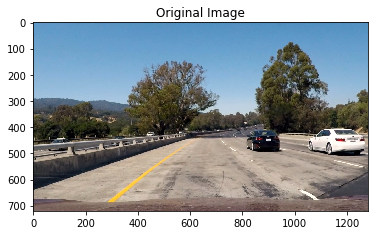

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

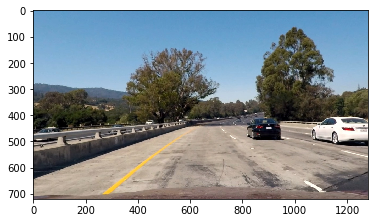

In [39]:
#Various stages in the pipeline test
image=mpimg.imread('test_images/test1.jpg')
final_out=adv_lane_find(image)

plt.imshow(final_out)



In [10]:
project_out = 'output_videos/project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")#subclip(40,50)
##clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(adv_lane_find) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_out, audio=False)

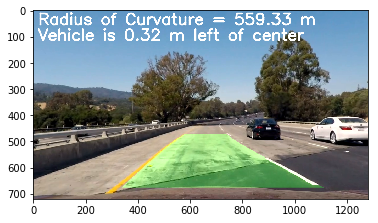

In [27]:
np_frame = clip1.get_frame(39.8)

#plt.imshow(np_frame)
plt.imshow(adv_lane_find(np_frame))

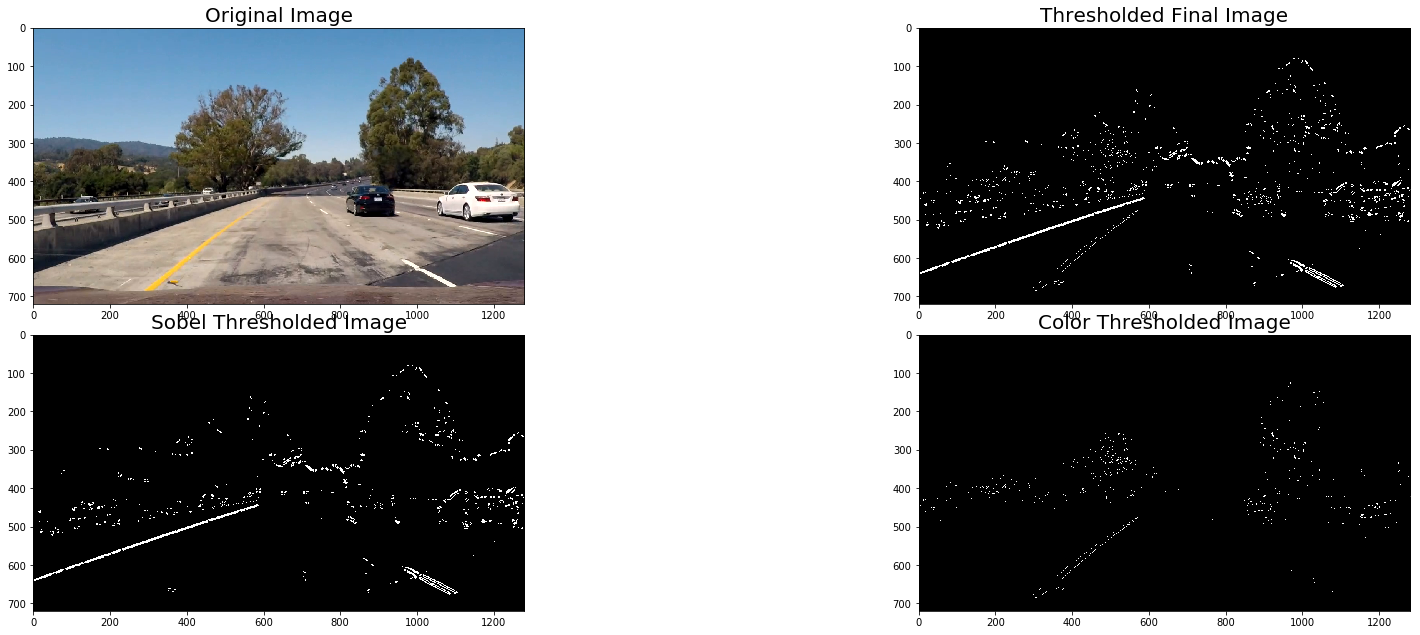

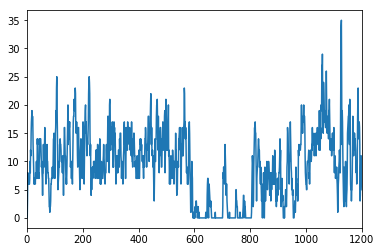

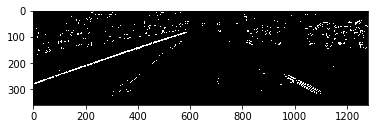

In [22]:
#Printing the thresholded output image
# Read in an image
image = np_frame

# Choose a Sobel kernel size
ksize = 25 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(45, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(50, 180))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(80, 180))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7 ,1.3))

sobel_combined = np.zeros_like(dir_binary)
sobel_combined[((gradx ==1) & (grady ==1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1 

sxbinary = color_threshold(image, thresh=(160,180))


# Combine the Sobel and color binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(sobel_combined == 1) | (sxbinary == 1)] = 1

# Plot the result
f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Thresholded Final Image', fontsize=20)
ax3.imshow(sobel_combined, cmap='gray')
ax3.set_title('Sobel Thresholded Image', fontsize=20)
ax4.imshow(sxbinary, cmap='gray')
ax4.set_title('Color Thresholded Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

# #Saving images
# cv2.imwrite('output_images/final_thresh.jpg', combined_binary*255)
# cv2.imwrite('output_images/sobel_thresh.jpg', sobel_combined*255)
# cv2.imwrite('output_images/color_thresh.jpg', sxbinary*255)

histogram = np.sum(combined_binary[combined_binary.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.xlim(0,1200)
plt.show()

plt.imshow(combined_binary[combined_binary.shape[0]//2:,:],cmap='gray')
plt.show()